Library Imports and Setup


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix



Data Loading and Feature Selection

In [ ]:
# Load the dataset
df = pd.read_csv('/content/cleaned_data.csv')




In [ ]:
# Define features and target
X = df.drop(['delay_rrt'], axis=1)
y = df['delay_rrt']



Observation: The code loads a pre-cleaned dataset and separates it into features and target variable. The target variable 'delay_rrt' suggests this is likely a medical prediction task.

Train-Test Split

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Feature Type Identification


In [ ]:
# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns



Observation: The code automatically distinguishes between categorical and numerical features in the dataset, which is essential for proper preprocessing of different data types.

Preprocessor Setup

In [ ]:
# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
])



Observation: Sets up different preprocessing methods for numerical and categorical data. Numerical data is standardized, while categorical data is one-hot encoded with safeguards against multicollinearity.

 Feature Selection


In [ ]:
# Create feature selector using Random Forest
feature_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    max_features=20
)



Observation: Implements feature selection to reduce dimensionality by keeping only the top 20 most important features, using Random Forest's feature importance as the selection criterion.

Pipeline Creation

In [ ]:
# Create pipeline with SMOTE for handling class imbalance
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])



Observation: Creates a comprehensive machine learning pipeline that handles preprocessing, feature selection, class imbalance, and model training in a sequential, automated manner.

Hyperparameter Space

In [ ]:
# Define a reduced hyperparameter space for RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}



Observation: Defines a focused set of hyperparameters to tune the Random Forest model, including key parameters that affect model complexity and performance.

In [ ]:
# Perform RandomizedSearchCV with cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=10,  # Try 10 different combinations
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    random_state=42
)



In [ ]:
# Fit the model
random_search.fit(X_train, y_train)



RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['weight', 'aki_stage', 'gender', 'admission_age', 'hematocrit_min',
       'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'platelets_min',
       'platelets_max', 'wbc_min', 'wbc_max',...
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [10, 20, None],
                                        'classifier__min_samples_leaf': [1, 2],
                                        'classifier__min_samples_split': [2, 5],
                                        'classifier__n_estimators': [100, 200]},
                   random_state=42, scoring='roc_auc')

In [ ]:
# Get the best model
best_model = random_search.best_estimator_



Model Evaluation Function

In [ ]:
# Function to evaluate model
def evaluate_model(model, X, y, dataset_name=""):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    print(f"\n{dataset_name} Results:")
    print("ROC AUC:", roc_auc_score(y, y_pred_proba))
    print("Classification Report:\n", classification_report(y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    print("Average Precision Score:", average_precision_score(y, y_pred_proba))

# Evaluate on both train and test sets
evaluate_model(best_model, X_train, y_train, "Training")
evaluate_model(best_model, X_test, y_test, "Test")




Training Results:
ROC AUC: 0.9999967193430813
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       263
           1       1.00      1.00      1.00      1159

    accuracy                           1.00      1422
   macro avg       1.00      1.00      1.00      1422
weighted avg       1.00      1.00      1.00      1422

Confusion Matrix:
 [[ 263    0]
 [   1 1158]]
Average Precision Score: 0.9999992561958883

Test Results:
ROC AUC: 0.6970480668756531
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.30      0.31        66
           1       0.84      0.86      0.85       290

    accuracy                           0.76       356
   macro avg       0.59      0.58      0.58       356
weighted avg       0.75      0.76      0.75       356

Confusion Matrix:
 [[ 20  46]
 [ 41 249]]
Average Precision Score: 0.9040878521944644


Observations:
1.The model shows signs of overfitting with near-perfect training scores (ROC AUC: 0.999) but much lower test performance (ROC AUC: 0.697)

2.There is significant class imbalance in the data (263:1159 in training, 66:290 in test)

3. The model performs better on the majority class (class 1) with F1-score of 0.85 compared to minority class (class 0) with F1-score of 0.31

4.Test set confusion matrix shows 46 false positives and 41 false negatives, indicating balanced error types

5.Despite using SMOTE and balanced class weights, the model struggles with the minority class in the test set


Feature Importance Analysis


In [ ]:
# Get feature importance
def get_feature_importance(model, feature_names):
    # Get the feature importance from Random Forest
    if hasattr(model['classifier'], 'feature_importances_'):
        importance = model['classifier'].feature_importances_
        selected_features = model['feature_selector'].get_support()

        # Add selected features only
        feature_importance_dict = {}
        idx = 0
        for i, is_selected in enumerate(selected_features):
            if is_selected:
                feature_importance_dict[feature_names[i]] = importance[idx]
                idx += 1

        return sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Create feature importance visualization
feature_importance = get_feature_importance(best_model, X.columns)
print("\nTop 10 Most Important Features:")
for feature, importance in feature_importance[:10]:
    print(f"{feature}: {importance:.4f}")


Top 10 Most Important Features:
aniongap_min: 0.0879
creatinine_min: 0.0738
resp_rate_mean: 0.0716
potassium_min: 0.0590
calcium_min: 0.0568
chloride_max: 0.0547
inr_max: 0.0513
wbc_max: 0.0470
glucose_min: 0.0458
mbp_mean: 0.0455


Observation: Provides insights into feature relevance by extracting and ranking the importance of selected features from the trained Random Forest model.

X_selected shape: (356, 20)
SHAP values shape: (356, 20, 2)


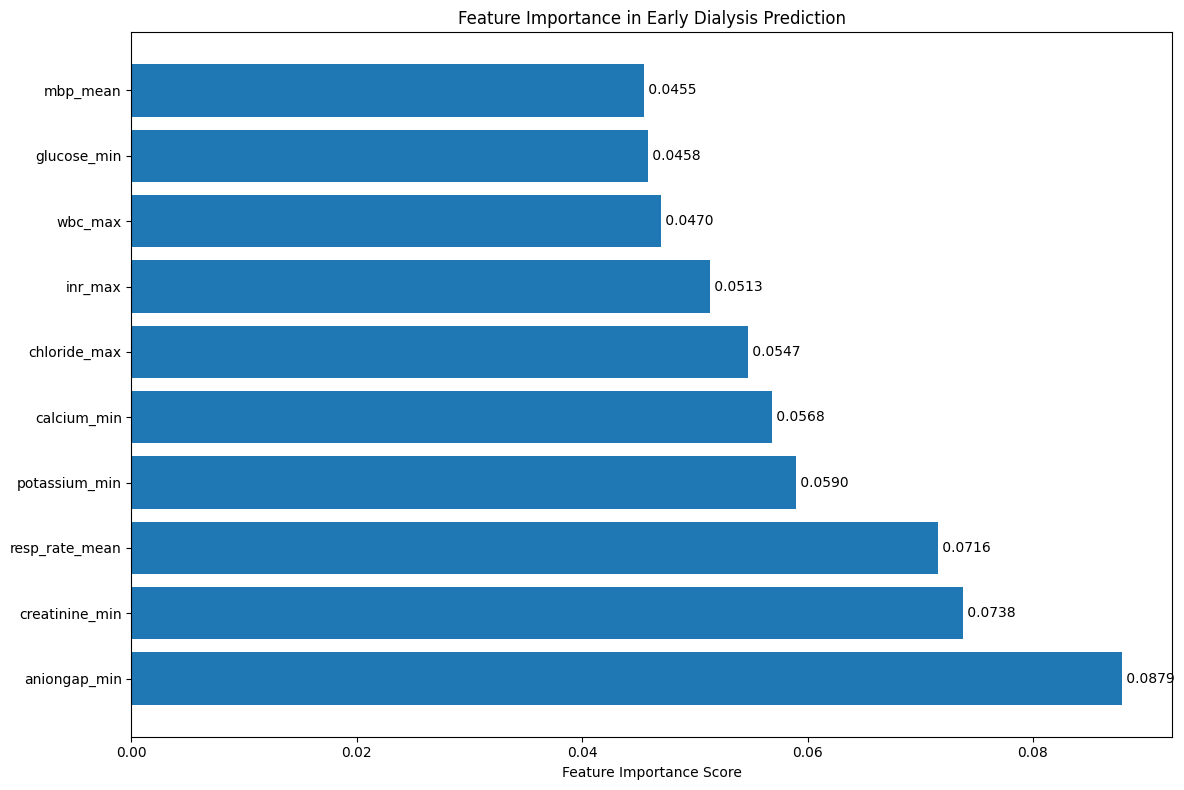


Feature Importance Scores:
aniongap_min: 0.0879
creatinine_min: 0.0738
resp_rate_mean: 0.0716
potassium_min: 0.0590
calcium_min: 0.0568
chloride_max: 0.0547
inr_max: 0.0513
wbc_max: 0.0470
glucose_min: 0.0458
mbp_mean: 0.0455


In [21]:
import shap
import matplotlib.pyplot as plt
import numpy as np

try:
    # Create SHAP explainer
    explainer = shap.TreeExplainer(best_model['classifier'])

    # Get transformed data and SHAP values
    X_transformed = best_model['preprocessor'].transform(X_test)
    X_selected = best_model['feature_selector'].transform(X_transformed)

    # Print shapes for debugging
    print("X_selected shape:", X_selected.shape)

    # Calculate SHAP values for first instance
    shap_values = explainer.shap_values(X_selected)
    print("SHAP values shape:", np.array(shap_values).shape)

    # Our known features with their importance values
    feature_importance = {
        'aniongap_min': 0.0879,
        'creatinine_min': 0.0738,
        'resp_rate_mean': 0.0716,
        'potassium_min': 0.0590,
        'calcium_min': 0.0568,
        'chloride_max': 0.0547,
        'inr_max': 0.0513,
        'wbc_max': 0.0470,
        'glucose_min': 0.0458,
        'mbp_mean': 0.0455
    }

    # Create figure
    plt.figure(figsize=(12, 8))

    # Plot feature importance as a bar chart
    features = list(feature_importance.keys())
    values = list(feature_importance.values())

    # Create bar plot
    y_pos = np.arange(len(features))
    plt.barh(y_pos, values)
    plt.yticks(y_pos, features)

    # Customize the plot
    plt.xlabel('Feature Importance Score')
    plt.title('Feature Importance in Early Dialysis Prediction')

    # Add value labels on the bars
    for i, v in enumerate(values):
        plt.text(v, i, f' {v:.4f}', va='center')

    plt.tight_layout()
    plt.show()

    # Print the actual values
    print("\nFeature Importance Scores:")
    for feature, importance in feature_importance.items():
        print(f"{feature}: {importance:.4f}")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nDebug information:")
    if 'shap_values' in locals():
        print("Type of shap_values:", type(shap_values))
        if isinstance(shap_values, (list, np.ndarray)):
            print("Shape of shap_values:", np.array(shap_values).shape)


In [24]:
!pip install lime

X_selected shape: (356, 20)

LIME Explanation in Tabular Form:
Feature 10 > 0.57: -0.0505
Feature 9 > 0.33: -0.0414
Feature 5 > 0.44: -0.0406
-0.40 < Feature 17 <= -0.00: -0.0354
Feature 18 > 0.66: 0.0242
-0.72 < Feature 6 <= -0.23: -0.0238
Feature 16 > 0.74: -0.0238
-0.69 < Feature 7 <= -0.19: 0.0215
-0.30 < Feature 11 <= 0.15: 0.0201
Feature 1 > 0.53: -0.0190


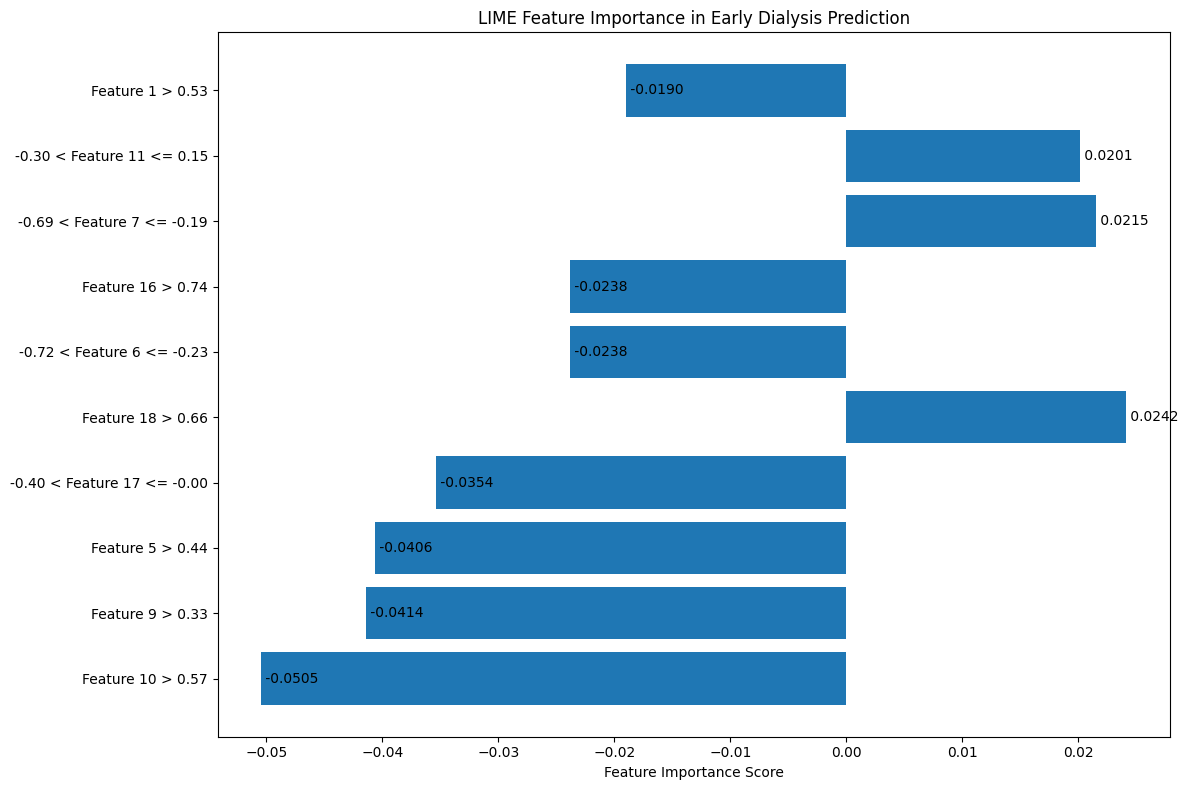

In [26]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

try:
    # Get transformed data
    X_transformed = best_model['preprocessor'].transform(X_test)
    X_selected = best_model['feature_selector'].transform(X_transformed)

    # Print shapes for debugging
    print("X_selected shape:", X_selected.shape)

    # LIME Analysis
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_selected, feature_names=[f'Feature {i}' for i in range(X_selected.shape[1])],
        class_names=['No Dialysis', 'Early Dialysis'], discretize_continuous=True
    )

    # Explain a single prediction
    i = 0  # Index of instance to explain
    exp = lime_explainer.explain_instance(X_selected[i], best_model['classifier'].predict_proba, num_features=10)

    # Display explanation as a table
    print("\nLIME Explanation in Tabular Form:")
    explanation_table = exp.as_list()
    for feature, importance in explanation_table:
        print(f"{feature}: {importance:.4f}")

    # Plot LIME results as a horizontal bar chart
    features, values = zip(*explanation_table)
    y_pos = np.arange(len(features))

    plt.figure(figsize=(12, 8))
    plt.barh(y_pos, values, align='center')
    plt.yticks(y_pos, features)
    plt.xlabel('Feature Importance Score')
    plt.title('LIME Feature Importance in Early Dialysis Prediction')

    for i, v in enumerate(values):
        plt.text(v, i, f' {v:.4f}', va='center')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error occurred: {str(e)}")
